In [1]:
from fastai.vision import *
from fastai.metrics import error_rate
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import torch, gc
# # torch.cuda.current_device()
# # torch.cuda.device(0)
# # torch.cuda.device_count()
# # torch.cuda.get_device_name(0)
# # torch.cuda.set_device(0)

In [3]:
tfms = get_transforms(xtra_tfms = cutout(n_holes=(1,3)))

## Create df for sampling

In [4]:
path = os.sys.path[0]
path_img = path + '/SCL_C02_data'
np.random.seed(2020)

In [5]:
samp_pct = 0.1

df_train = pd.read_csv(path_img+'/train.csv')
dict_labels = dict(zip([str(x) for x in range(10)],['0' + str(x) for x in range(10)]))
df_train['category'] = df_train.category.astype(str).replace(dict_labels)
df_train['filename'] = 'train' + '/' + df_train.category + '/' + df_train.filename
df_train.columns = ['name','label']
df_sample = df_train.groupby('label', group_keys = False).apply(lambda x: x.sample(frac = samp_pct, random_state = 2020))
display(
    pd.concat(
        [df_train.label.value_counts(normalize = True).rename('Train'),
         df_sample.label.value_counts(normalize = True).rename('Sample')],
        axis = 1
    ).T
)

df_test = pd.read_csv(path_img+'/test.csv')
df_test['filename'] = 'test' + '/' + df_test.filename
df_test.columns = ['name','label']

00        01        02        03        04        05        06  \
Train   0.025457  0.025638  0.025495  0.025647  0.025647  0.025059  0.025059   
Sample  0.025441  0.025631  0.025536  0.025631  0.025631  0.025062  0.025062   

              07        08        09  ...        32        33        34  \
Train   0.025239  0.025619  0.025600  ...  0.020466  0.005437  0.024660   
Sample  0.025252  0.025631  0.025631  ...  0.020505  0.005411  0.024682   

              35        36        37        38        39        40        41  
Train   0.025220  0.025486  0.016367  0.025362  0.025410  0.025438  0.025258  
Sample  0.025252  0.025536  0.016328  0.025346  0.025441  0.025441  0.025252  

[2 rows x 42 columns]

## Full Data, ResNet152

In [6]:
bs = 16

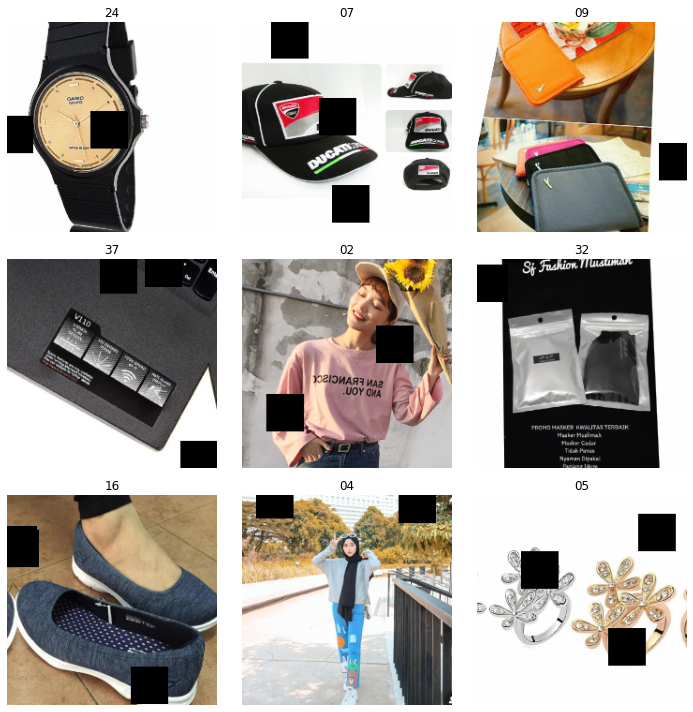

In [7]:
data = ImageDataBunch.from_df(path = path_img, df = df_train, seed = 2020, valid_pct = 0.2, ds_tfms = tfms, size = 224, bs = bs).normalize(imagenet_stats)
data.show_batch(rows = 3, figsize = (10,10))

In [8]:
learn = cnn_learner(data, models.resnet152, metrics = error_rate)

In [9]:
learn.model.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [ ]:
learn.fit_one_cycle(10)

In [ ]:
learn.save('resnet152_10e_cutout')

In [ ]:
learn.fit_one_cycle(10)

In [ ]:
learn.save('resnet152_20e_cutout')

## Load Sample

In [8]:
bs = 16

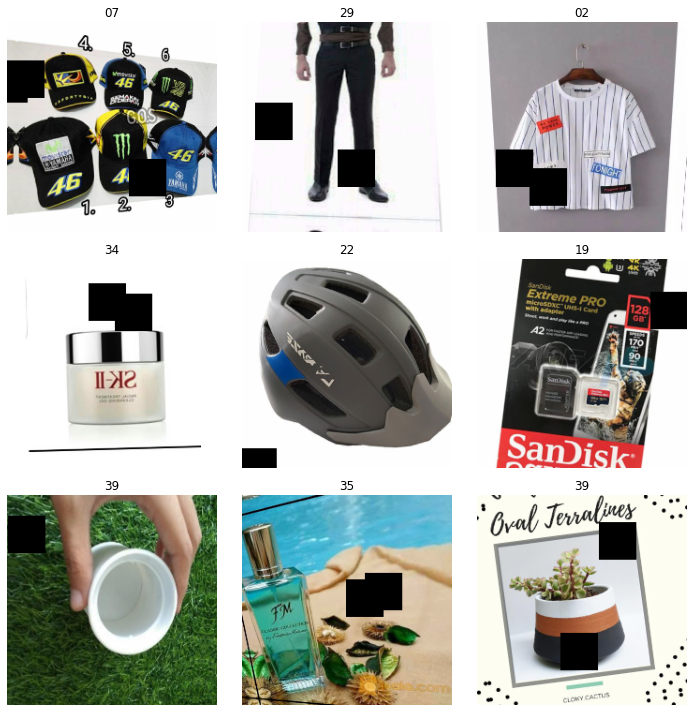

In [8]:
data = ImageDataBunch.from_df(path = path_img, df = df_sample, seed = 2020, valid_pct = 0.2, ds_tfms = tfms, size = 224, bs = bs).normalize(imagenet_stats)
data.show_batch(rows = 3, figsize = (10,10))

In [9]:
# Clear cuda memory
gc.collect()
torch.cuda.empty_cache()

## Training on Sample Data

### ResNet152

In [10]:
learn = cnn_learner(data, models.resnet152, metrics = error_rate)

In [11]:
learn.model.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [12]:
learn.fit_one_cycle(5)

In [13]:
learn.save('resnet152_10pct_5e_cutout')

### ResNet50

In [14]:
learn = cnn_learner(data, models.resnet50, metrics = error_rate)

In [15]:
learn.model.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [16]:
learn.fit_one_cycle(5)

In [17]:
learn.save('resnet50_10pct_5e_cutout')

### DenseNet201

In [20]:
learn = cnn_learner(data, models.densenet201, metrics = error_rate)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to C:\Users\ponglao/.cache\torch\checkpoints\densenet201-c1103571.pth


In [21]:
learn.model.cuda()

Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine

In [22]:
learn.fit_one_cycle(5)

In [23]:
learn.save('densenet201_10pct_5e_cutout')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


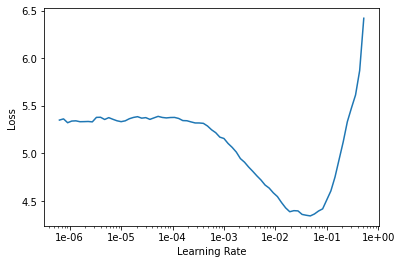

In [11]:
learn.lr_find()
learn.recorder.plot()

### Results

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds) == len(losses) == len(idxs)

True

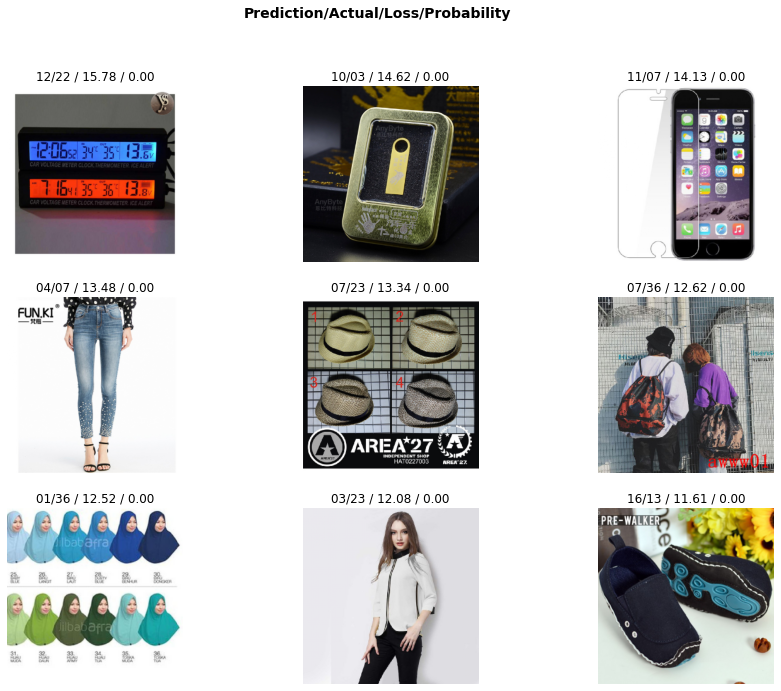

In [12]:
interp.plot_top_losses(9, figsize = (15,11))

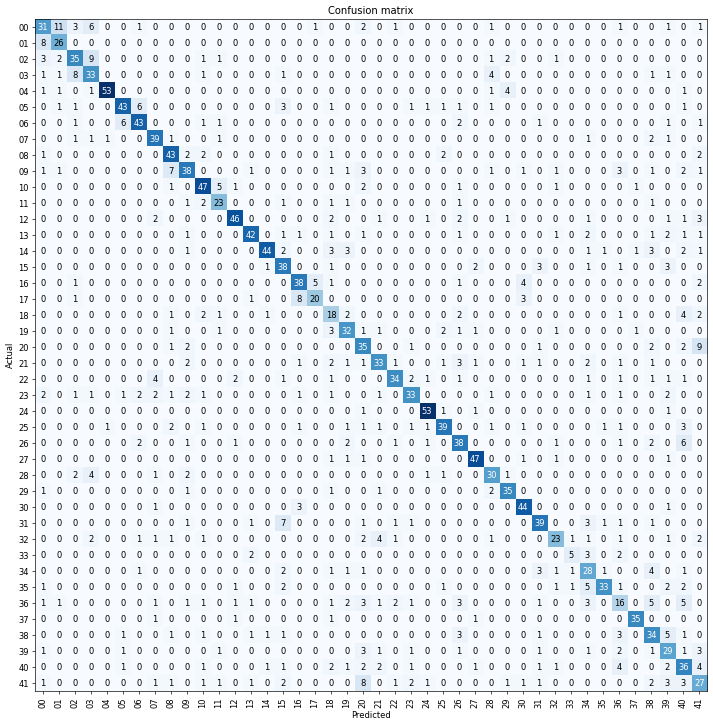

In [13]:
interp.plot_confusion_matrix(figsize = (12,12), dpi = 60)

In [14]:
interp.most_confused(min_val = 2)

[('00', '01', 11),
 ('02', '03', 9),
 ('20', '41', 9),
 ('01', '00', 8),
 ('03', '02', 8),
 ('17', '16', 8),
 ('41', '20', 8),
 ('09', '08', 7),
 ('31', '15', 7),
 ('00', '03', 6),
 ('05', '06', 6),
 ('06', '05', 6),
 ('26', '40', 6),
 ('10', '11', 5),
 ('16', '17', 5),
 ('35', '34', 5),
 ('36', '38', 5),
 ('36', '40', 5),
 ('38', '39', 5),
 ('03', '28', 4),
 ('04', '29', 4),
 ('16', '30', 4),
 ('18', '40', 4),
 ('22', '07', 4),
 ('28', '03', 4),
 ('32', '21', 4),
 ('34', '38', 4),
 ('40', '36', 4),
 ('40', '41', 4),
 ('00', '02', 3),
 ('02', '00', 3),
 ('05', '15', 3),
 ('09', '20', 3),
 ('09', '36', 3),
 ('12', '41', 3),
 ('14', '18', 3),
 ('14', '19', 3),
 ('14', '38', 3),
 ('15', '31', 3),
 ('15', '39', 3),
 ('17', '30', 3),
 ('19', '18', 3),
 ('21', '26', 3),
 ('25', '40', 3),
 ('30', '16', 3),
 ('31', '34', 3),
 ('33', '34', 3),
 ('34', '31', 3),
 ('36', '20', 3),
 ('36', '26', 3),
 ('36', '34', 3),
 ('38', '26', 3),
 ('38', '36', 3),
 ('39', '20', 3),
 ('39', '41', 3),
 ('41', '

### Mixup & Label Smoothing

#### Mixup

In [2]:
from exp.nb_10 import *

In [3]:
Γ = lambda x: x.lgamma().exp()

In [4]:
class NoneReduce():
    def __init__(self, loss_func): 
        self.loss_func,self.old_red = loss_func,None
        
    def __enter__(self):
        if hasattr(self.loss_func, 'reduction'):
            self.old_red = getattr(self.loss_func, 'reduction')
            setattr(self.loss_func, 'reduction', 'none')
            return self.loss_func
        else: return partial(self.loss_func, reduction='none')
        
    def __exit__(self, type, value, traceback):
        if self.old_red is not None: setattr(self.loss_func, 'reduction', self.old_red)
            
from torch.distributions.beta import Beta

def unsqueeze(input, dims):
    for dim in listify(dims): input = torch.unsqueeze(input, dim)
    return input

def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss

class MixUp(Callback):
    _order = 90 #Runs after normalization and cuda
    def __init__(self, α:float=0.4): self.distrib = Beta(tensor([α]), tensor([α]))
    
    def begin_fit(self): self.old_loss_func,self.run.loss_func = self.run.loss_func,self.loss_func
    
    def begin_batch(self):
        if not self.in_train: return #Only mixup things during training
        λ = self.distrib.sample((self.yb.size(0),)).squeeze().to(self.xb.device)
        λ = torch.stack([λ, 1-λ], 1)
        self.λ = unsqueeze(λ.max(1)[0], (1,2,3))
        shuffle = torch.randperm(self.yb.size(0)).to(self.xb.device)
        xb1,self.yb1 = self.xb[shuffle],self.yb[shuffle]
        self.run.xb = lin_comb(self.xb, xb1, self.λ)
        
    def after_fit(self): self.run.loss_func = self.old_loss_func
    
    def loss_func(self, pred, yb):
        if not self.in_train: return self.old_loss_func(pred, yb)
        with NoneReduce(self.old_loss_func) as loss_func:
            loss1 = loss_func(pred, yb)
            loss2 = loss_func(pred, self.yb1)
        loss = lin_comb(loss1, loss2, self.λ)
        return reduce_loss(loss, getattr(self.old_loss_func, 'reduction', 'mean'))

nfs = [32,64,128,256,512]

def get_learner(nfs, data, lr, layer, loss_func=F.cross_entropy,
                cb_funcs=None, opt_func=optim.SGD, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return Learner(model, data, loss_func, lr=lr, cb_funcs=cb_funcs, opt_func=opt_func)

cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback, 
        ProgressCallback,
        partial(BatchTransformXCallback, norm_imagenette),
        MixUp]

#### Label Smoothing

In [18]:
nfs = [32,64,128,256,512]

In [19]:
tfms = get_transforms()
bs = 32

In [20]:
il = ImageList.from_files(path_img, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=42, num_workers=12)

In [ ]:
ll.val

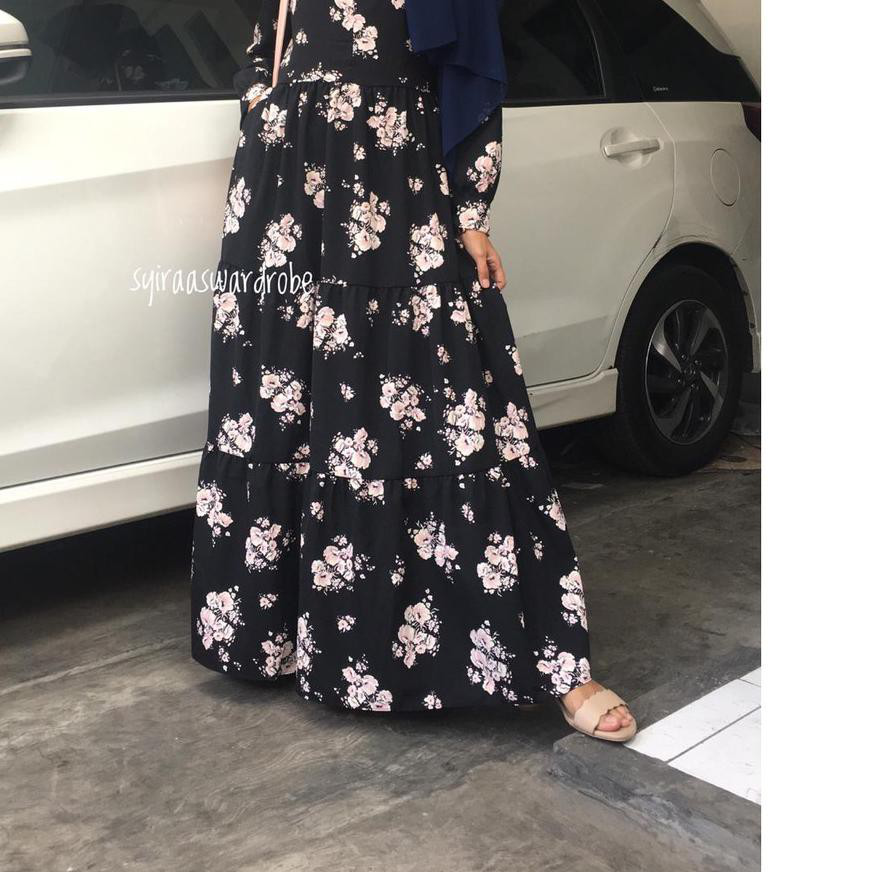

In [25]:
PIL.Image.open(ll.val.x.items[3])

In [21]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, ε:float=0.1, reduction='mean'):
        super().__init__()
        self.ε,self.reduction = ε,reduction
    
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return lin_comb(loss/c, nll, self.ε)

In [22]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        ProgressCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [23]:
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs, loss_func=LabelSmoothingCrossEntropy())

In [24]:
learn.fit(1)

BrokenPipeError: [Errno 32] Broken pipe

## Full Data, ResNet50

In [17]:
bs = 32

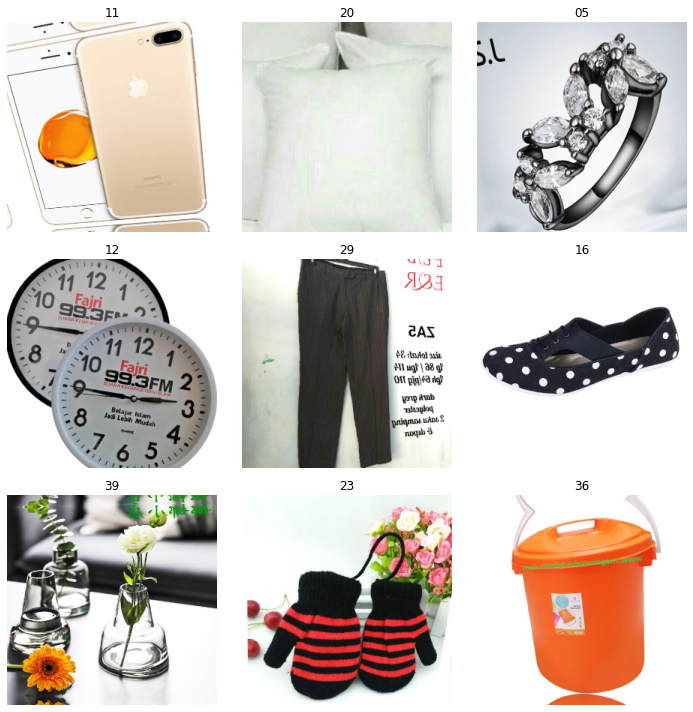

In [8]:
data = ImageDataBunch.from_df(path = path_img, df = df_train, seed = 2020, valid_pct = 0.2, ds_tfms = get_transforms(), size = 280, bs = bs).normalize(imagenet_stats)
data.show_batch(rows = 3, figsize = (10,10))

In [10]:
learn = cnn_learner(data, models.resnet50, metrics = error_rate)

In [11]:
learn.model.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


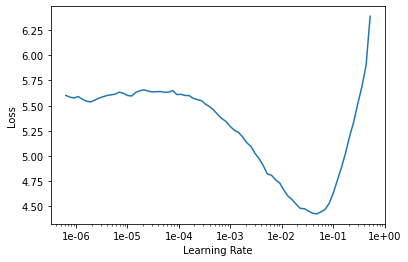

In [12]:
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(10, max_lr = slice(1e-6,2e-3))

In [14]:
learn.save('resnet50_10e')

### Results

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds) == len(losses) == len(idxs)

True

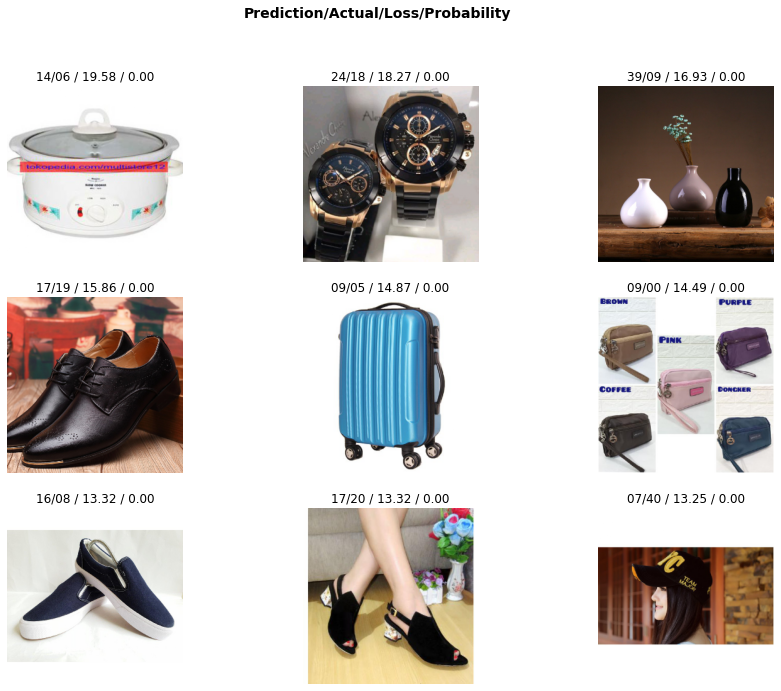

In [16]:
interp.plot_top_losses(9, figsize = (15,11))

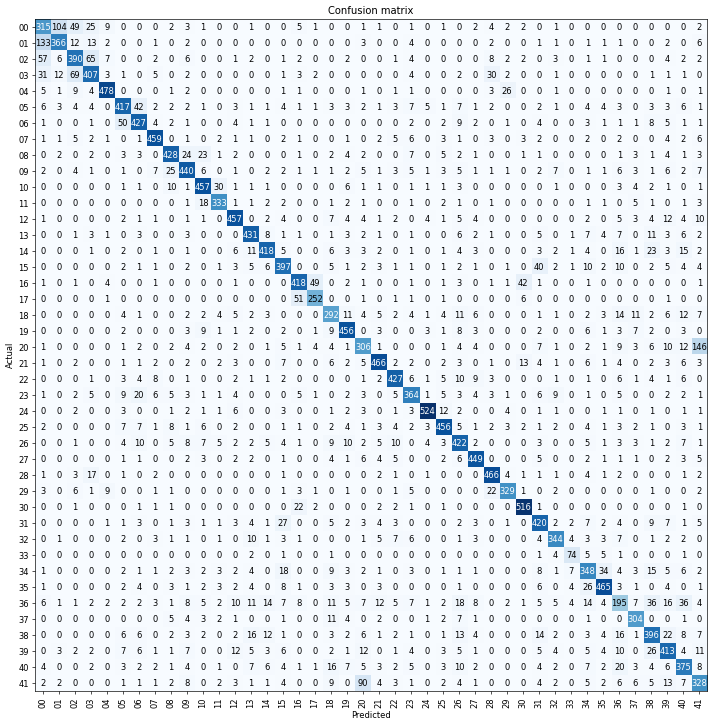

In [17]:
interp.plot_confusion_matrix(figsize = (12,12), dpi = 60)

In [18]:
interp.most_confused(min_val = 2)

[('20', '41', 146),
 ('01', '00', 133),
 ('00', '01', 104),
 ('41', '20', 90),
 ('03', '02', 69),
 ('02', '03', 65),
 ('02', '00', 57),
 ('17', '16', 51),
 ('06', '05', 50),
 ('00', '02', 49),
 ('16', '17', 49),
 ('05', '06', 42),
 ('16', '30', 42),
 ('15', '31', 40),
 ('36', '38', 36),
 ('36', '40', 36),
 ('34', '35', 34),
 ('03', '00', 31),
 ('03', '28', 30),
 ('10', '11', 30),
 ('31', '15', 27),
 ('04', '29', 26),
 ('35', '34', 26),
 ('39', '38', 26),
 ('00', '03', 25),
 ('09', '08', 25),
 ('08', '09', 24),
 ('08', '10', 23),
 ('14', '38', 23),
 ('29', '28', 22),
 ('30', '16', 22),
 ('38', '39', 22),
 ('23', '06', 20),
 ('40', '36', 20),
 ('11', '10', 18),
 ('34', '15', 18),
 ('36', '26', 18),
 ('28', '03', 17),
 ('14', '36', 16),
 ('36', '39', 16),
 ('38', '13', 16),
 ('38', '36', 16),
 ('40', '18', 16),
 ('14', '40', 15),
 ('34', '38', 15),
 ('18', '36', 14),
 ('36', '14', 14),
 ('36', '34', 14),
 ('38', '31', 14),
 ('01', '03', 13),
 ('21', '30', 13),
 ('38', '26', 13),
 ('41', '

## Fit More

In [9]:
learn.load('resnet50_10e')

Learner(data=ImageDataBunch;

Train: LabelList (84314 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: CategoryList
03,03,03,03,03
Path: C:\Users\ponglao\Desktop\Shopee Code League\C02\SCL_C02_data;

Valid: LabelList (21078 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: CategoryList
39,05,10,23,15
Path: C:\Users\ponglao\Desktop\Shopee Code League\C02\SCL_C02_data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNor

In [10]:
learn.fit_one_cycle(4, max_lr = slice(1e-6,2e-3))

In [11]:
learn.save('resnet50_14e')

In [12]:
learn.fit_one_cycle(6, max_lr = slice(1e-6,2e-3))

In [13]:
learn.save('resnet50_20e')

In [19]:
learn.load('resnet50_20e')

Learner(data=ImageDataBunch;

Train: LabelList (84314 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: CategoryList
03,03,03,03,03
Path: C:\Users\ponglao\Desktop\Shopee Code League\C02\SCL_C02_data;

Valid: LabelList (21078 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: CategoryList
39,05,10,23,15
Path: C:\Users\ponglao\Desktop\Shopee Code League\C02\SCL_C02_data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNor

In [20]:
learn.fit_one_cycle(10, max_lr = slice(1e-6,2e-3))

In [21]:
learn.save('resnet50_30e')

### Get predictions

In [6]:
bs = 32

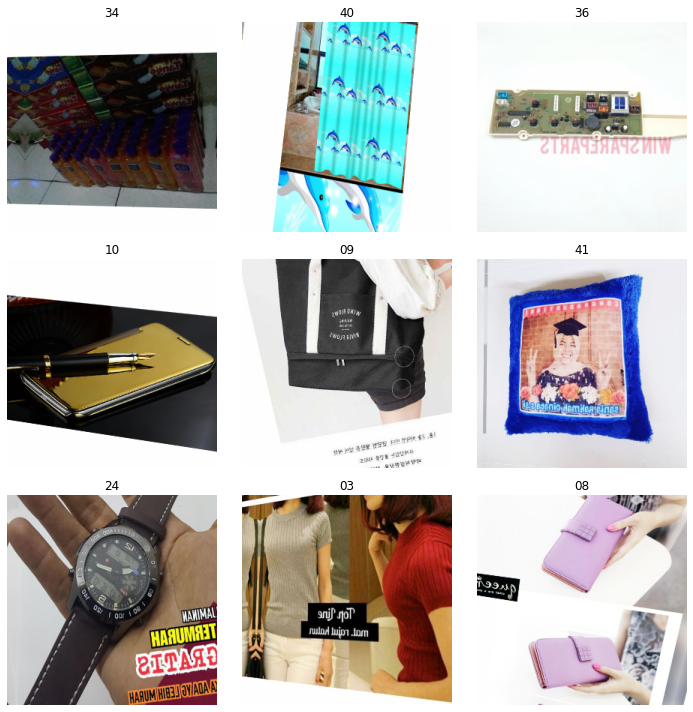

In [7]:
data = ImageDataBunch.from_folder(path = path_img, test = 'test', seed = 2020, valid_pct = 0.2, ds_tfms = get_transforms(), size = 280, bs = bs).normalize(imagenet_stats)
data.show_batch(rows = 3, figsize = (10,10))

In [8]:
learn = cnn_learner(data, models.resnet50, metrics = error_rate)

In [9]:
learn.model.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [10]:
learn.load('resnet50_20e')

Learner(data=ImageDataBunch;

Train: LabelList (84314 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: CategoryList
00,00,00,00,00
Path: C:\Users\ponglao\Desktop\Shopee Code League\C02\SCL_C02_data;

Valid: LabelList (21078 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: CategoryList
29,05,14,34,34
Path: C:\Users\ponglao\Desktop\Shopee Code League\C02\SCL_C02_data;

Test: LabelList (12192 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: EmptyLabelList
,,,,
Path: C:\Users\ponglao\Desktop\Shopee Code League\C02\SCL_C02_data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3):

In [11]:
preds,y = learn.get_preds(ds_type = DatasetType.Test)

In [12]:
y = torch.argmax(preds, dim=1)

In [15]:
df_test_preds = pd.concat([pd.Series([str(x)[66:] for x in data.test_dl.dataset.items]), pd.Series(y)], axis = 1)
df_test_preds.columns = ['filename','category']
df_test_preds = df_test_preds[df_test_preds.filename.isin(df_test.name.str[5:])].set_index('filename')
df_test_preds.to_csv(path + '/31GB_peter_02_resnet50_20e.csv')

## EfficientNet

In [7]:
from efficientnet_pytorch import EfficientNet

In [8]:
model = EfficientNet.from_name('efficientnet-b0')

In [9]:
model._fc = nn.Linear(1280, data.c)

In [10]:
learn = Learner(data, model, metrics = error_rate)

In [11]:
learn.model.cuda()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit(10)

In [ ]:
get_transforms()